# WQU Capstone project - Short-term trading strategy on G10 currencies
## Notebook 7 - Training and testing

* Sergey Chigrinov - chigrinov.s.88@gmail.com
* Dhruv Agrawal -  dhruva1@stanfordalumni.org
* Man Sing Ho - mshoalbert@gmail.com

### Jun-Aug-2020

In this workbook we're choosing the right ML algorithms based on cross validation, building an ensemple and testing it.

In [1]:
import sys
import os
#insert you own path or use relative path
path_to_project = os.path.realpath('..')
sys.path.append(path_to_project)

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm import tqdm
from multiprocessing import cpu_count
import pickle
import warnings
warnings.filterwarnings('ignore')

In [3]:
import WQUcapstoneCode.ml.ml as wqu
#from WQUcapstoneCode.ml.ml import cv_with_custom_score, train_valid_test_split, get_pyfolio_simple_tear_sheet

In [4]:
from pyfolio.timeseries import perf_stats 
from pyfolio import create_simple_tear_sheet

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-talk')
plt.style.use('bmh')

In [6]:
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
#from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.calibration import calibration_curve
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [7]:
tickers = ['AUD/USD','AUD/CAD','AUD/JPY','EUR/USD','GBP/USD','NZD/USD','USD/CAD', 'USD/JPY']

We are here to look at the data input for each currency pair to ensure same period is adopted in the analysis across currency pair. We take the overlapping time period for all currency pairs, which are the maximum of each of the currency minimal time observed and the minimum of each of the currency maximum time observed.

In [8]:
min_period = dt.datetime(1999, 1, 1, 0, 0) #initialize the smallest min_period
max_period = dt.datetime.now() #initalize the largest min_period for comparison

for ticker in tickers:
    preprocessed_path= os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv')
    data = pd.read_csv(preprocessed_path, index_col=0, parse_dates=True)

    if max(data.index) < max_period:
        max_period = max(data.index)
        
    if min(data.index) > min_period:
        min_period = min(data.index)

In [9]:
# Checking the maximun period to be used.
max_period

Timestamp('2020-06-17 23:00:00')

In [10]:
# Checking the minimum period to be used.
min_period

Timestamp('2015-10-06 13:00:00')

Below we calculate feature inportance based on Random Forest, and then teach a number of ML algorythms using different sets of features.

In [12]:
RANDOM_STATE = 1

# Training set variable initiation
# ----------------------------------------------------------
score_dict = {}
rtn_dict = {}
test_statistic =  {}
rtns_test = {}

n_splits = 5 # for cross validation

models = {'LightGBM':LGBMClassifier(random_state = RANDOM_STATE), 
          'XGBoost':XGBClassifier(seed = RANDOM_STATE), 
         'Tuned RF':RandomForestClassifier(criterion='entropy', class_weight='balanced_subsample', bootstrap=False,
                            random_state=RANDOM_STATE), # these are the parameters recomended in the book
         'RF':RandomForestClassifier(random_state=RANDOM_STATE),
          'ExtraTrees':ExtraTreesClassifier(random_state=RANDOM_STATE),
         'AdaBoost': AdaBoostClassifier(n_estimators=1000, random_state=RANDOM_STATE),
         'Scaler->PCA4->RF':make_pipeline(StandardScaler(),PCA(n_components=4),RandomForestClassifier(random_state=RANDOM_STATE)),
         'Scaler->PCA4->LogRegr': make_pipeline(StandardScaler(), PCA(n_components=4), LogisticRegression(max_iter=1000, tol=0.1)),
         'Scaler->SVM': make_pipeline(StandardScaler(), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA4->SVM': make_pipeline(StandardScaler(), PCA(n_components=4), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA20->SVM': make_pipeline(StandardScaler(), PCA(n_components=20), svm.SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE)),
         'Scaler->PCA6->Naive Bayes':make_pipeline(StandardScaler(), PCA(n_components=6), GaussianNB()),
          'Scaler->Naive Bayes':make_pipeline(StandardScaler(), GaussianNB())
         }                   
vc = VotingClassifier(estimators=[('RF',models['RF']),
                                  ('ExtraTrees',models['ExtraTrees']),
                                  ('Scaler->PCA4->LogRegr', models['Scaler->PCA4->LogRegr']),
                                  ('Scaler->SVM',models['Scaler->PCA4->SVM'])],
                     voting = 'soft')
models['Voting'] = vc

      
# Loop for each currency pair
# ----------------------------------------------------------
for ticker in tickers:

    # To populate current time for running the code
    d = dt.datetime.now().strftime('%I:%M%p')
    print(f'{d}: Cross-validating on {ticker}')
    
     # Data input 
    preprocessed_path= os.path.join(path_to_project, 'preprocessed_data', ''.join(ticker.split('/')) + '_feat.csv')
    data = pd.read_csv(preprocessed_path, index_col=0, parse_dates=True)
    
    # Standardize data period across all currency pair for easy comparison
    data = data.loc[min_period:max_period] # Sergey: not necessary - the sata is already within this interval anyway
    
    # splitting the data into training, validation and testing set.
    X_train, Y_train, target_rtns_train, X_test, Y_test, target_rtns_test, _, _, _ = wqu.train_valid_test_split(data,'75:25')
    
    # here we use all training set to calculate feature importances, which is a cheat because later part of cross validated set becomes validation set. 
    # However, it was found that features are relatively stable across subsets. 
    # In any case, the result will be tested using validation set
    all_feature_cols, ex_frdiff_cols, frdiff_cols, top_feat = wqu.get_feature_types(X_train, Y_train, models['Tuned RF'])
    
    features = {'all_feature_cols':all_feature_cols, 
                'ex_frdiff_cols':ex_frdiff_cols,
                'frdiff_cols':frdiff_cols,
                'top_feat_RF': top_feat
               }
    
    # Define k-fold cross validation here
    cv = KFold(n_splits=n_splits, shuffle=False)
    
    # Training set
    score_dict[ticker] = {}
    rtn_dict[ticker] = {}
       
    # Test set
    test_statistic[ticker] = {}
    rtns_test[ticker] =  {}
    
    for n,cols in features.items():
        
        # Testing set within a currency pair
        score_dict[ticker][n] = {}
        rtn_dict[ticker][n] = {}
        
        # Testing set within a currency pair
        test_statistic[ticker][n] =  {}
        rtns_test[ticker][n] =  {}
        
        for m,c in models.items():
            
            # Training and cross validating all algorithms
            n_scores = cross_val_score(c, X_train[cols], Y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')           
            return_stats = wqu.cv_with_custom_score(c, X_train[cols], Y_train, target_rtns_train, n_folds=n_splits)
            
            rtn_dict[ticker][n][m] = return_stats
            score_dict[ticker][n][m] = np.mean(n_scores)
    
            # Testing set for all algorithms
            # Here we retrain the model by using validation data as this is more recent data to out-sample data
            rtn = c.fit(X_train[cols],Y_train).predict(X_test[cols]) * target_rtns_test            
            rtns_test[ticker][n][m] = rtn
            test_statistic[ticker][n][m] = perf_stats(rtn)

09:16PM: Cross-validating on AUD/USD
09:23PM: Cross-validating on AUD/CAD
09:30PM: Cross-validating on AUD/JPY
09:37PM: Cross-validating on EUR/USD
09:44PM: Cross-validating on GBP/USD
09:51PM: Cross-validating on NZD/USD
09:58PM: Cross-validating on USD/CAD
10:05PM: Cross-validating on USD/JPY


Export data as pickle file as generation of the data takes ~40min to export the training, validation and testing results.

In [14]:
pickle_path_cv = os.path.join(path_to_project, 'preprocessed_data', 'algos_cv.p')
with open(pickle_path_cv, 'wb') as output_file:
    pickle.dump({'returns':rtn_dict, 'accuracy': score_dict, 'test_statistic': test_statistic, 'returns_test': rtns_test}, output_file)
    

Load pickle data from archive.

In [11]:
pickle_path_cv = os.path.join(path_to_project, 'preprocessed_data', 'algos_cv.p')
with open(pickle_path_cv, "rb") as input_file:
    d = pickle.load(input_file)
    rtn_dict = d['returns']
    score_dict = d['accuracy']
    test_statistic = d['test_statistic']
    rtns_test = d['returns_test']

In [12]:
# an example of available statistics
rtn_dict['AUD/USD']['ex_frdiff_cols']['Voting']

Annual return          0.255086
Cumulative returns     0.787169
Annual volatility      0.119664
Sharpe ratio           1.959311
Calmar ratio           2.200358
Stability              0.936107
Max drawdown          -0.115929
Omega ratio            1.302163
Sortino ratio          2.921133
Skew                  -0.299181
Kurtosis              -1.222110
Tail ratio             1.079052
Daily value at risk   -0.014146
dtype: float64

Now that we have score_dict, rtn_dict and sharp_dict objects, we can slice and dice them. We can either select the algorythms that perform better on average on all currency pairs, or we can use the best algorythms for a selected currency pair.
Please see below the average characteristics of algorythms.

# Traing set

### Accuracy map across currencies for training set

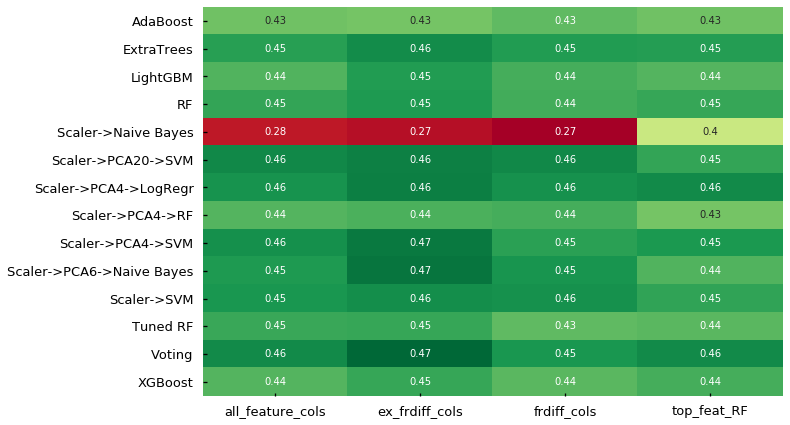

In [13]:
sns.heatmap(pd.concat([pd.DataFrame(v) for k,v in score_dict.items()]).groupby(level=0).mean(),
            annot=True, cbar=False, cmap="RdYlGn")

For accuracy:
- From a model perspective, it is observed that most models have a similar accuracy score with the exception of Naive Bayes classification.
- From a features perspective, we do not see a significant difference for one feature set against the others.


### Returns, Volatility and Sharp Ratio across currency pairs for training set

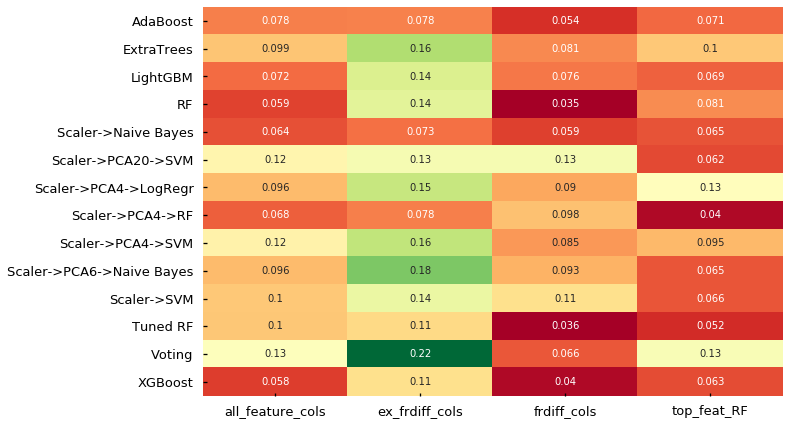

In [14]:
sns.heatmap(wqu.get_stat_means_frame(rtn_dict, 'Annual return'), annot=True, cbar=False, cmap="RdYlGn")

For return across currency pairs:
- From a model perspective, it is observed that extra tress, logistic regression with 4 principal components, support vector machine with 4 principal components, support vector machine with 20 principal components and voting classifier performs relatively better than other algorithm.
- From a feature perspective, it is observed that models with features without undergoing fractional differencing performs better than other feature sets.


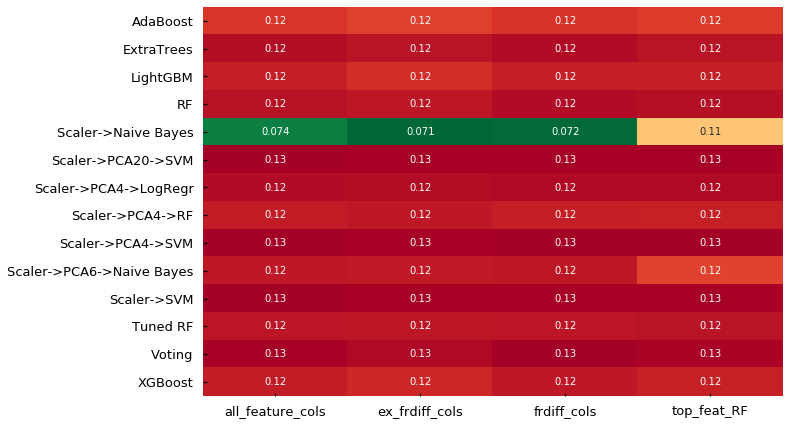

In [15]:
sns.heatmap(wqu.get_stat_means_frame(rtn_dict, 'Annual volatility'), annot=True, cbar=False, cmap="RdYlGn_r") 

For standard deviations across currency pairs:
- From a model perspective, it is observed that Naive Bayes model gives minimal standard deviations while other models give similar level of volatility.
- From a features perspective, we do not observe significant different across features with the exception of the feature set with Naïve Bayes model.


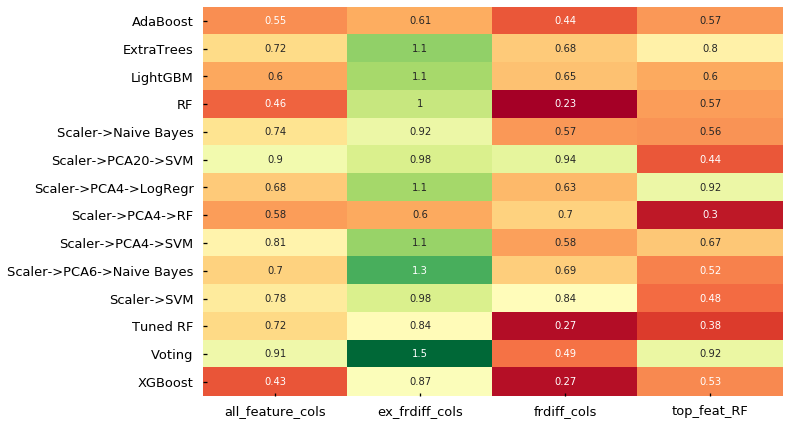

In [16]:
sns.heatmap(wqu.get_stat_means_frame(rtn_dict, 'Sharpe ratio'), annot=True, cbar=False, cmap="RdYlGn")

For Sharpe Ratio across currency pairs:
- From a model perspective, given the volatility is largely consistent across features, similar to the observations we see from the return, extra tress, logistic regression with 4 principal components, voting classifier performs relatively better, followed by support vector machine with 20 principal components and support vector machine with 4 principal components than other algorithms.
- From a features perspective, given the volatility is largely consistent across features, it is observed that models with features without undergoing fractional differencing performs better than other feature sets.

### Returns, Volatility and Sharp Ratio across currency pairs for test set

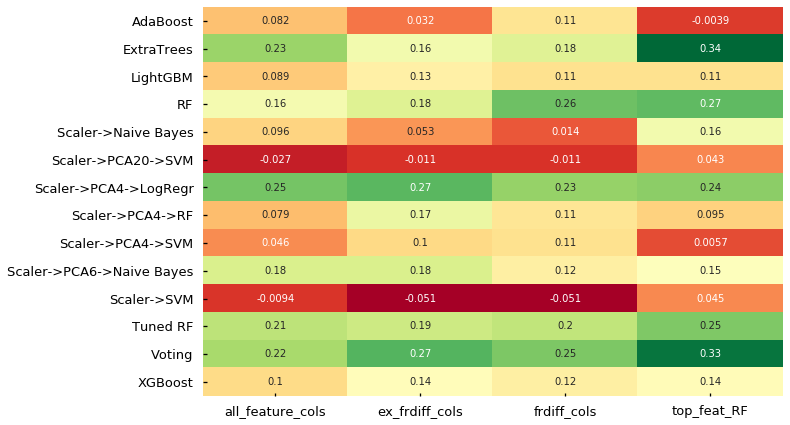

In [17]:
sns.heatmap(wqu.get_stat_means_frame(test_statistic, 'Annual return'), annot=True, cbar=False, cmap="RdYlGn")

For return across currency pairs:
- From a model perspective, it is observed that voting classifier, logistic regression with 4 principal components and extra trees as our candidate models performs well, with Voting works best, followed by logistic regression with 4 principal components and extra tress. Support vector machine with 4 principal components still gives fair prediction results while support vector machine with 20 principal components performs poorly, suggesting potential overfitting and data mining bias with 20 principal components.
- From a feature perspective, we could see models with features without undergoing fractional differencing performs fairly with other feature sets.


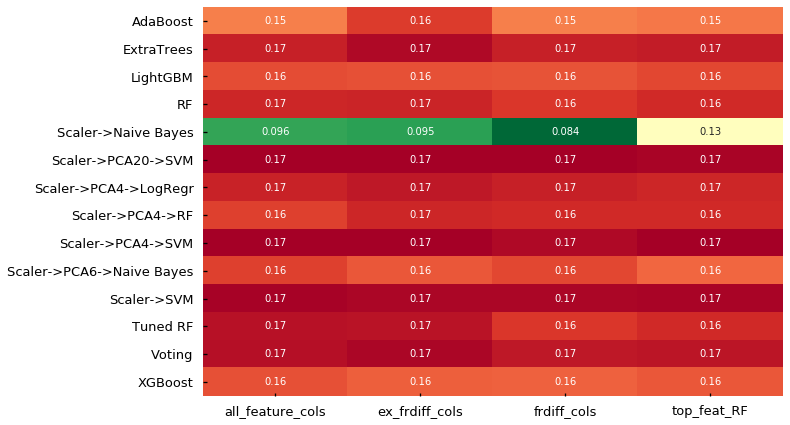

In [23]:
sns.heatmap(wqu.get_stat_means_frame(test_statistic, 'Annual volatility'), annot=True, cbar=False, cmap="RdYlGn_r")

For standard deviations across currency pairs:
- From a model perspective, similar to cross validation results, it is observed that Naive Bayes model gives minimal standard deviations while other models give similar level of volatility.
- From a features perspective, similar to cross validation results, we do not observe significant different across features with the exception of the feature set with Naïve Bayes model.


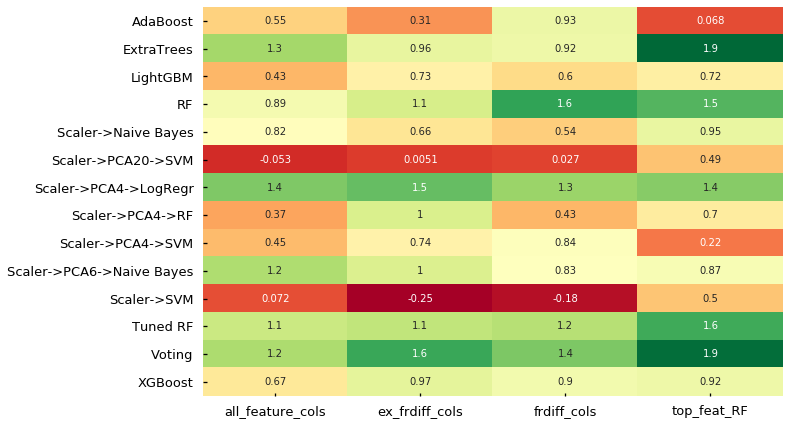

In [26]:
sns.heatmap(wqu.get_stat_means_frame(test_statistic, 'Sharpe ratio'), annot=True, cbar=False, cmap="RdYlGn")

For Sharpe Ratio across currency pairs:
- From a model perspective, given the volatility is largely consistent across features, it is observed that voting classifier, logistic regression with 4 principal components and extra trees as our candidate models performs well, with Voting works best, followed by logistic regression with 4 principal components and extra tress. Support vector machine with 4 principal components gives below-average prediction results while support vector machine with 20 principal components performs poorly, suggesting potential overfitting and data mining bias with 20 principal components.
- From a feature perspective, we could see models with features without undergoing fractional differencing performs fairly with other feature sets.

The above reinforced our observations in the cross validation during this out-of-sample testing. It is concluded the voting classifier, logistic regression with 4 principal components as our candidate models performs best while extra trees performs well in the out-sample testing, among the same set of features without undergoing fractional differencing.
Considering the consistency of model performance between validation and out-sample testing phase, we will be using voting classifier, logistic regression with 4 principal components with features without undergoing fractional differencing.


### Exploring results
Based on cross validation on the training set we would have chosen Voting classifier/ex_frdiff_colls and Logistic regression with 4PCA/ex_frdiff_colls.
Test set has confirmed that this algorithm has shown one of the best results. While some other combinations may have shown better results, it may be luck, but cross validation is evidense. 

Let's explore its returns

### Voting classifier/ex_frdiff_colls

In [65]:
model = 'Voting'
features = 'ex_frdiff_cols'
print(f'Test statistics by currency for {model}')
pd.DataFrame({ticker:test_statistic[ticker][features][model] for ticker in tickers})

Test statistics by currency for Voting


,AUD/USD,AUD/CAD,AUD/JPY,EUR/USD,GBP/USD,NZD/USD,USD/CAD,USD/JPY
Annual return,0.384233,0.066266,-0.045543,0.191420,0.451847,0.287230,0.415249,0.418786
Cumulative returns,0.318001,0.057344,-0.039344,0.138793,0.401199,0.235421,0.335654,0.309037
Annual volatility,0.229111,0.169866,0.227131,0.113092,0.167395,0.205618,0.113603,0.144371
Sharpe ratio,1.533854,0.462332,-0.092077,1.605388,2.312098,1.330792,3.115784,2.496230
Calmar ratio,1.287201,0.259592,-0.113335,2.765099,3.661038,1.640592,6.969177,4.213188
Stability,0.519992,0.002505,0.148500,0.662575,0.691629,0.502736,0.841434,0.508772
Max drawdown,-0.298503,-0.255270,-0.401842,-0.069227,-0.123420,-0.175077,-0.059584,-0.099399
Omega ratio,1.253103,1.073588,0.986801,1.252394,1.408593,1.216745,1.555572,1.458502
Sortino ratio,2.399636,0.666194,-0.127989,2.602744,3.799611,2.033548,5.022079,4.288866
Skew,0.101537,-0.046331,-0.053205,0.201202,0.079883,0.023771,-0.154583,0.248693


Let's explore individual currency returns.

Start date,2019-02-27
End date,2020-06-17
Total months,10
,Backtest
Annual return,38.4%
Cumulative returns,31.8%
Annual volatility,22.9%
Sharpe ratio,1.53
Calmar ratio,1.29
Stability,0.52
Max drawdown,-29.9%


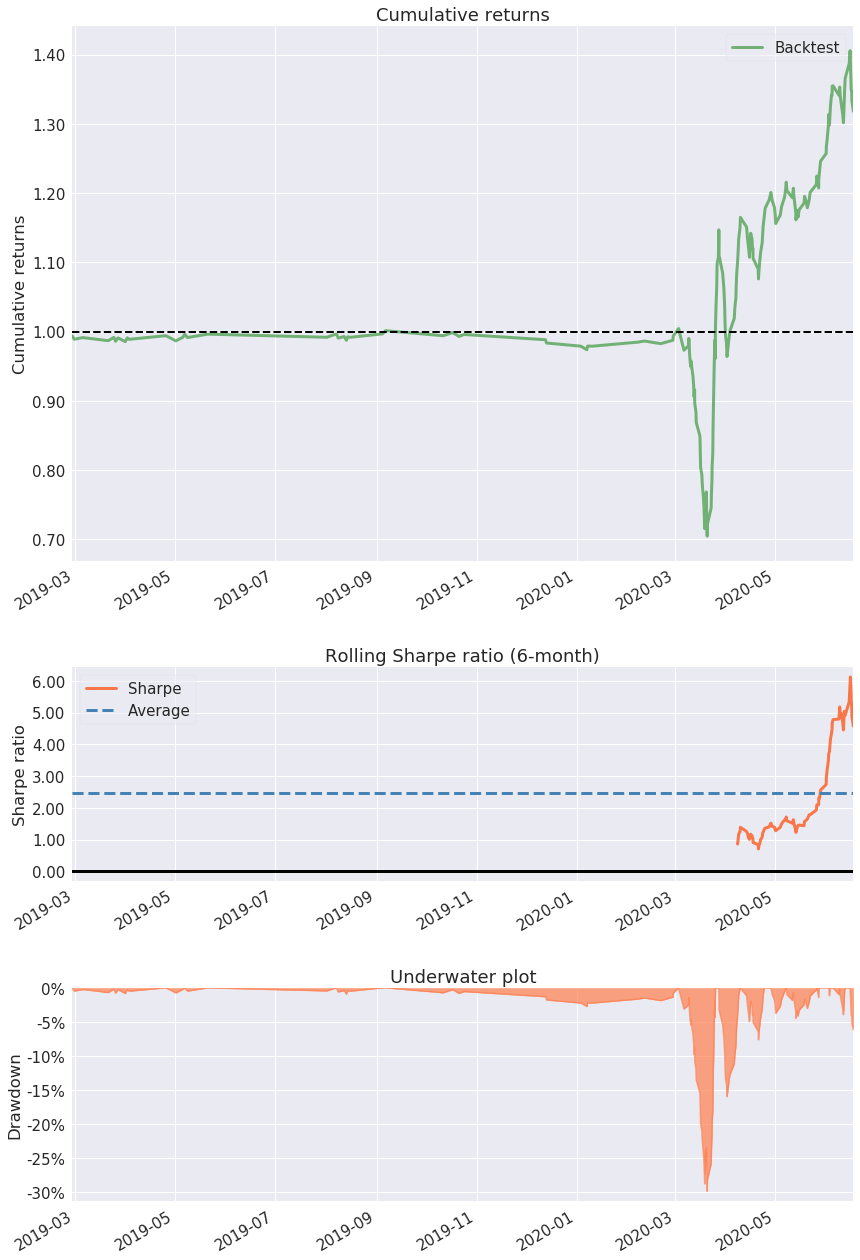

In [28]:
create_simple_tear_sheet(rtns_test['AUD/USD'][features][model])

Start date,2019-05-29
End date,2020-06-17
Total months,10
,Backtest
Annual return,6.6%
Cumulative returns,5.7%
Annual volatility,17.0%
Sharpe ratio,0.46
Calmar ratio,0.26
Stability,0.00
Max drawdown,-25.5%


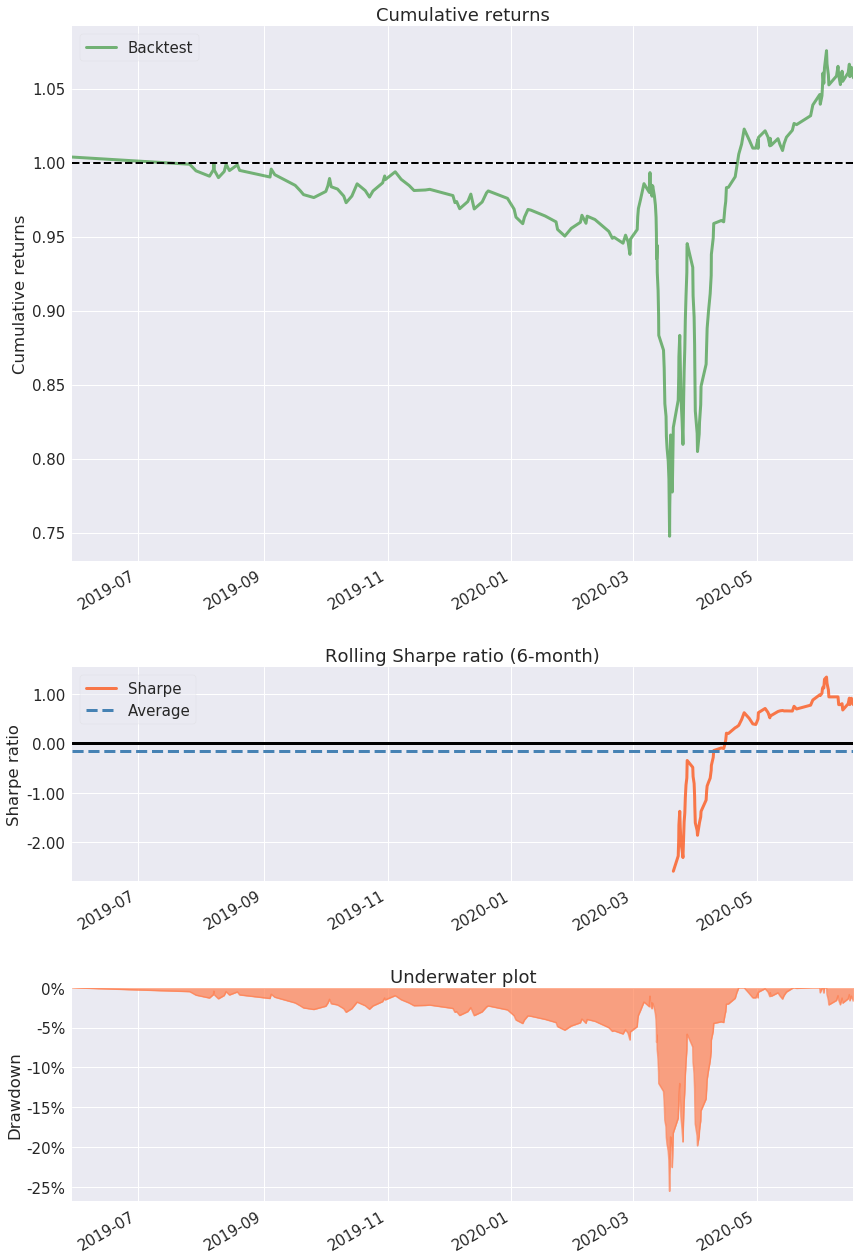

In [66]:
create_simple_tear_sheet(rtns_test['AUD/CAD'][features][model])

Start date,2019-02-15
End date,2020-06-17
Total months,10
,Backtest
Annual return,-4.6%
Cumulative returns,-3.9%
Annual volatility,22.7%
Sharpe ratio,-0.09
Calmar ratio,-0.11
Stability,0.15
Max drawdown,-40.2%


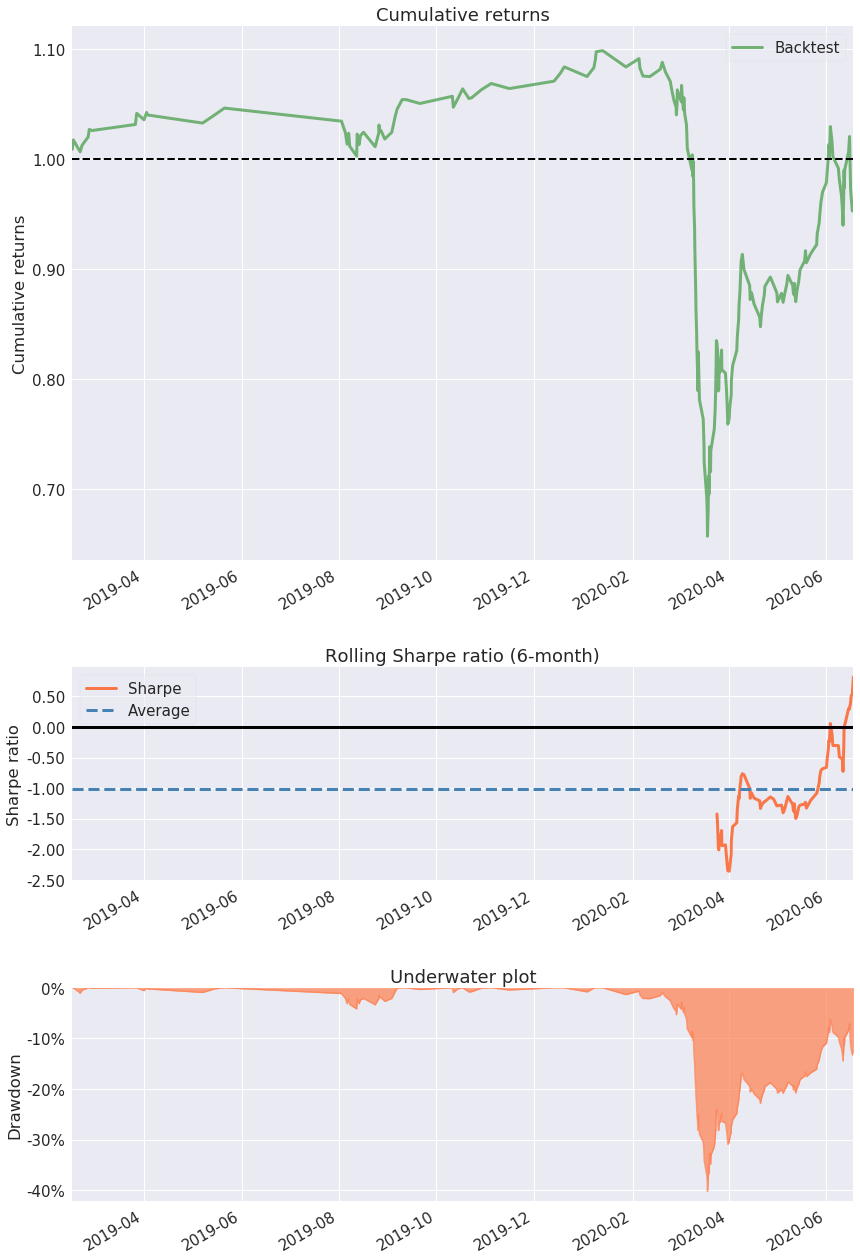

In [30]:
create_simple_tear_sheet(rtns_test['AUD/JPY'][features][model])

Start date,2019-06-20
End date,2020-06-16
Total months,10
,Backtest
Annual return,45.2%
Cumulative returns,40.1%
Annual volatility,16.7%
Sharpe ratio,2.31
Calmar ratio,3.66
Stability,0.69
Max drawdown,-12.3%


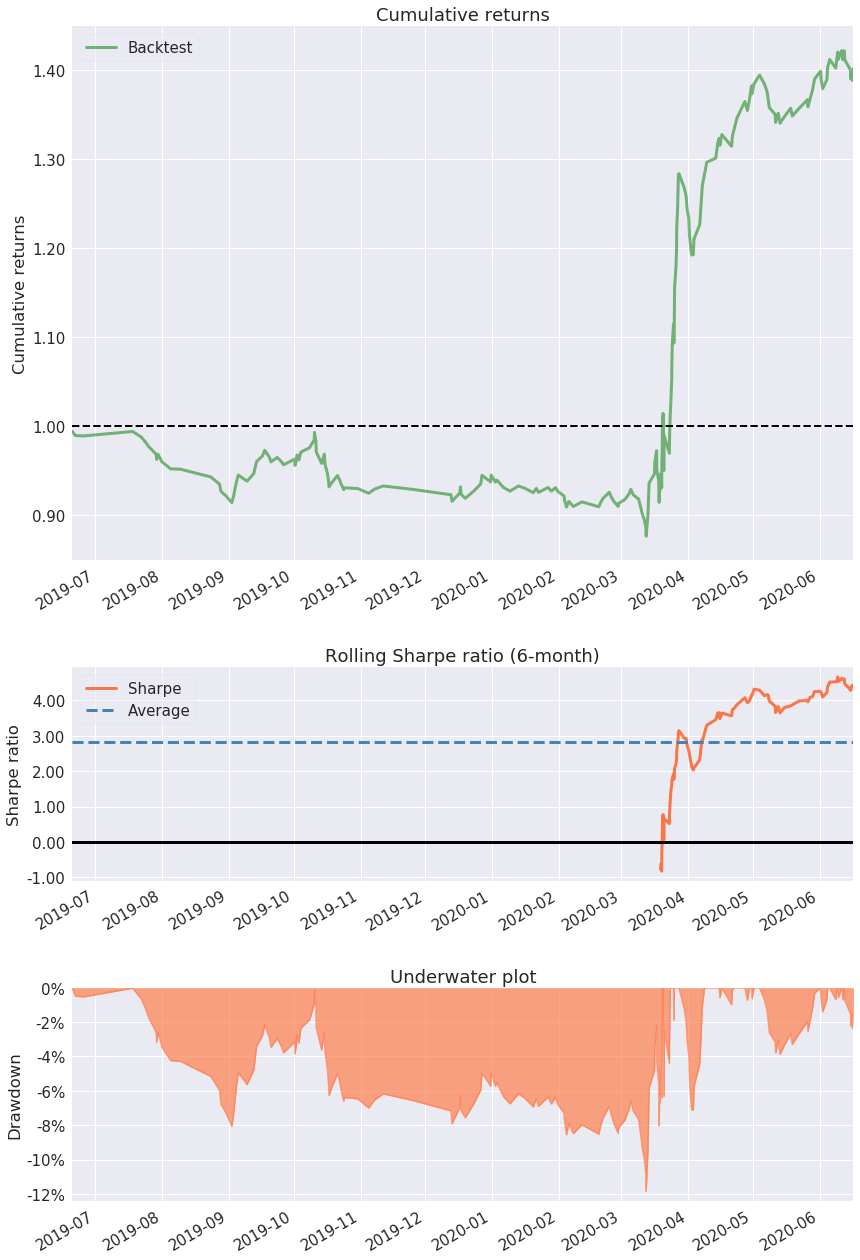

In [31]:
create_simple_tear_sheet(rtns_test['GBP/USD'][features][model])

Start date,2019-01-21
End date,2020-06-17
Total months,10
,Backtest
Annual return,28.7%
Cumulative returns,23.5%
Annual volatility,20.6%
Sharpe ratio,1.33
Calmar ratio,1.64
Stability,0.50
Max drawdown,-17.5%


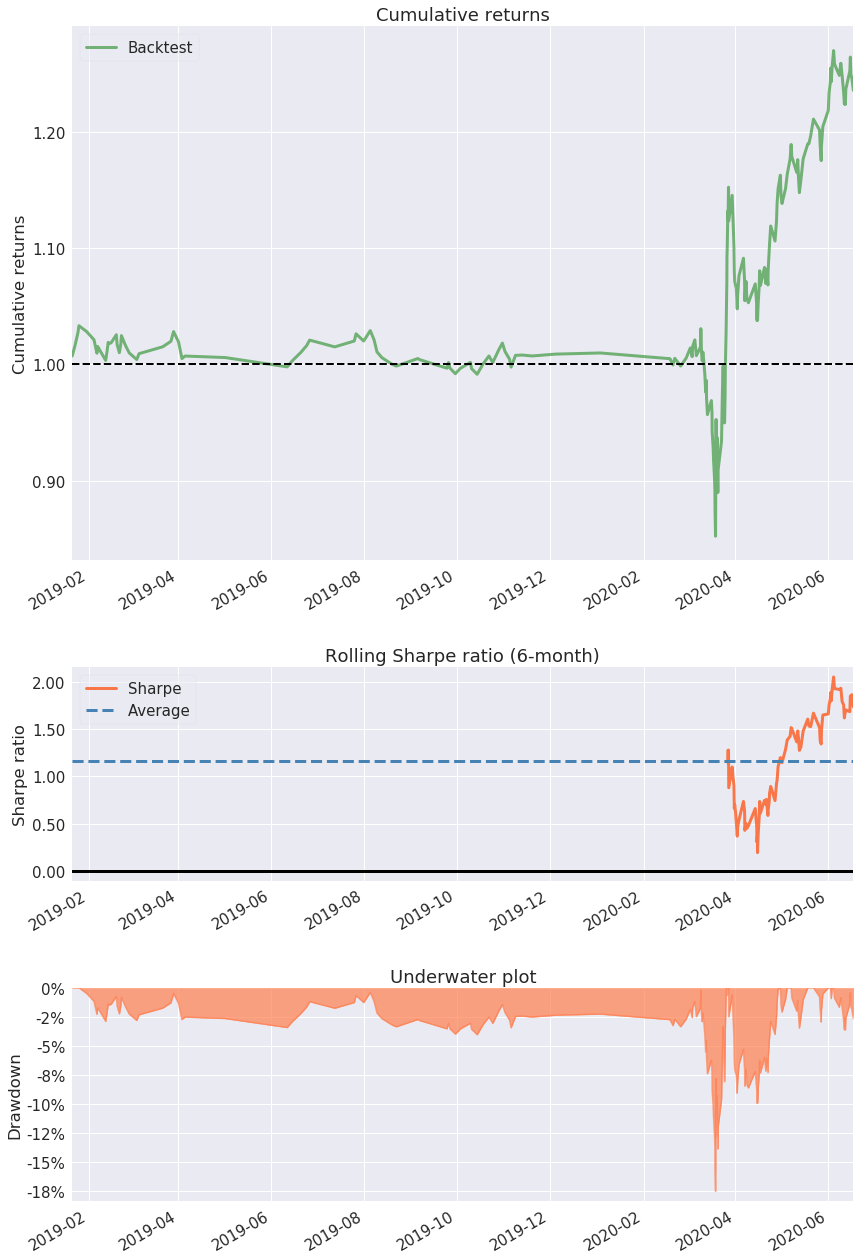

In [32]:
create_simple_tear_sheet(rtns_test['NZD/USD'][features][model])

Start date,2018-08-23
End date,2020-06-17
Total months,8
,Backtest
Annual return,19.1%
Cumulative returns,13.9%
Annual volatility,11.3%
Sharpe ratio,1.61
Calmar ratio,2.77
Stability,0.66
Max drawdown,-6.9%


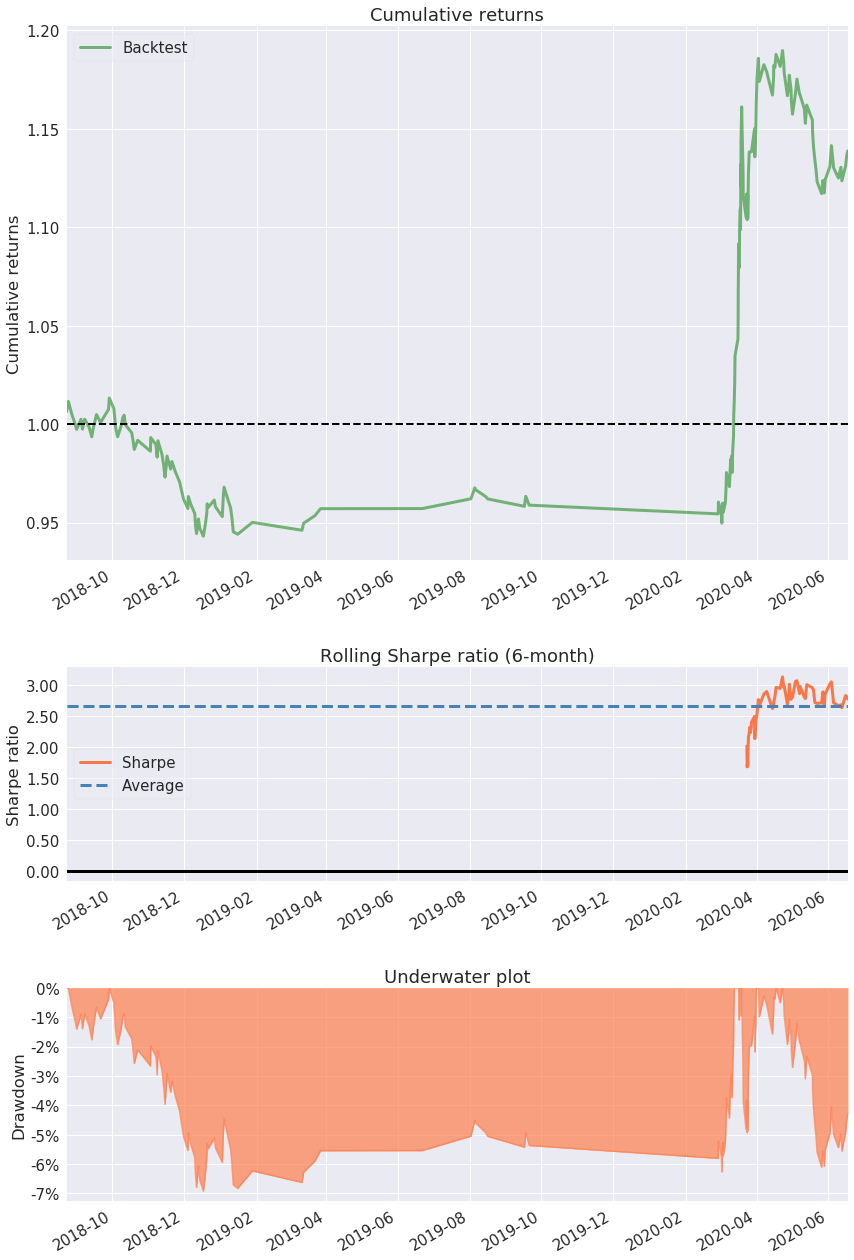

In [67]:
create_simple_tear_sheet(rtns_test['EUR/USD'][features][model])

Start date,2018-09-04
End date,2020-06-16
Total months,10
,Backtest
Annual return,23.3%
Cumulative returns,19.1%
Annual volatility,11.5%
Sharpe ratio,1.88
Calmar ratio,1.85
Stability,0.48
Max drawdown,-12.6%


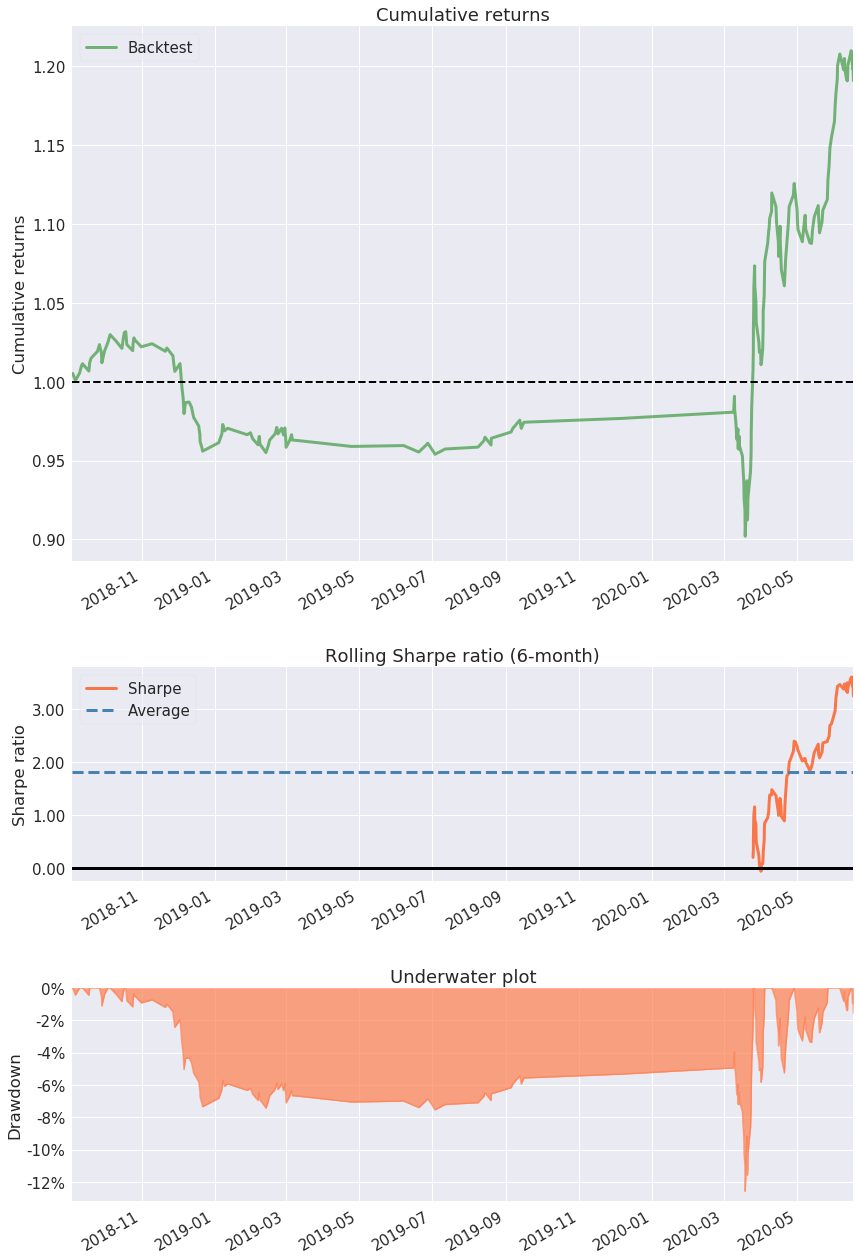

In [63]:
create_simple_tear_sheet(rtns_test['USD/CAD'][features][model])

Start date,2018-02-15
End date,2020-06-17
Total months,9
,Backtest
Annual return,60.6%
Cumulative returns,44.0%
Annual volatility,14.4%
Sharpe ratio,3.37
Calmar ratio,6.93
Stability,0.78
Max drawdown,-8.8%


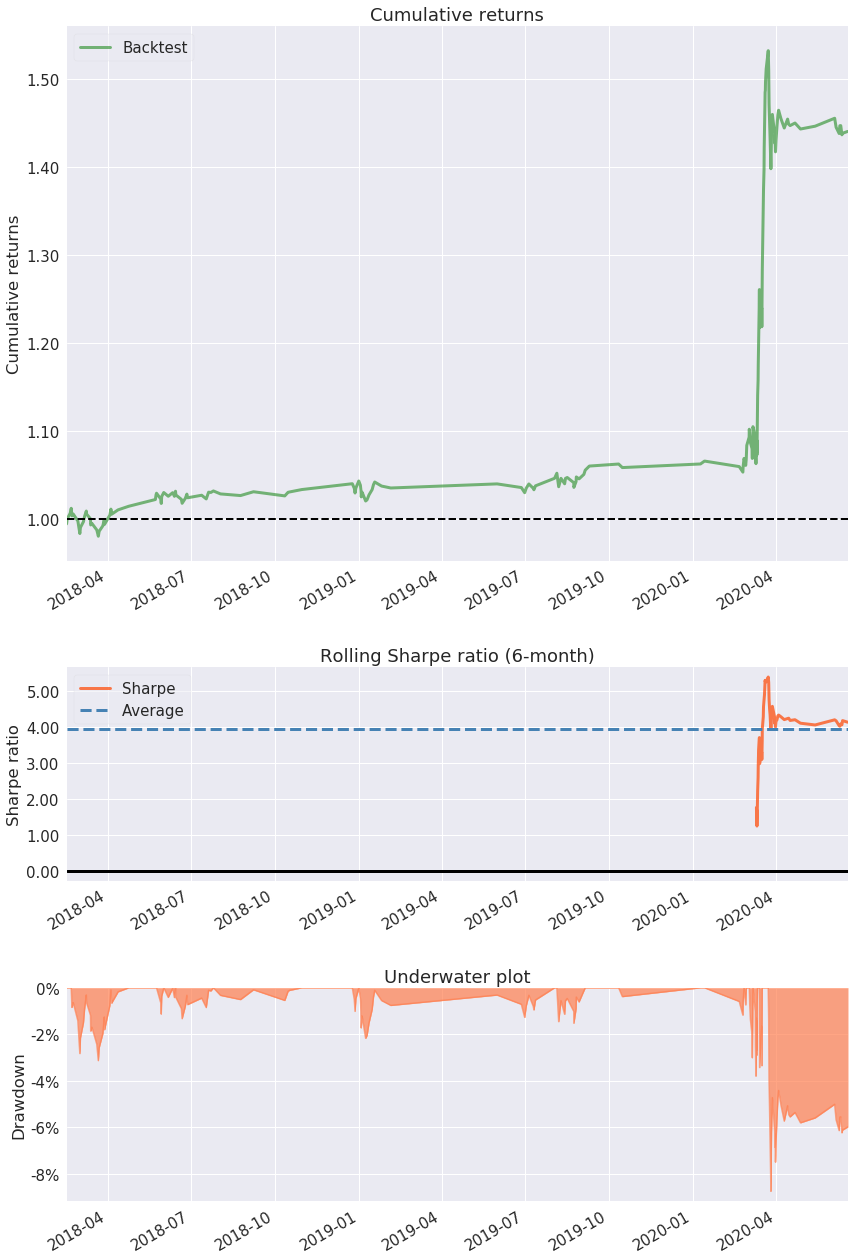

In [64]:
create_simple_tear_sheet(rtns_test['USD/JPY'][features][model])

### Logistic 4PCA/ex_frdiff_colls

In [68]:
model = 'Scaler->PCA4->LogRegr'
features = 'ex_frdiff_cols'
print(f'Test statistics by currency for {model}')
pd.DataFrame({ticker:test_statistic[ticker][features][model] for ticker in tickers})

Test statistics by currency for Scaler->PCA4->LogRegr


,AUD/USD,AUD/CAD,AUD/JPY,EUR/USD,GBP/USD,NZD/USD,USD/CAD,USD/JPY
Annual return,0.402140,0.014362,-0.036862,0.071676,0.453605,0.403155,0.233154,0.606371
Cumulative returns,0.332466,0.012470,-0.031825,0.052711,0.402734,0.327920,0.190824,0.440352
Annual volatility,0.229031,0.166429,0.209485,0.115192,0.163695,0.201345,0.114973,0.143672
Sharpe ratio,1.590511,0.168570,-0.074946,0.658251,2.368122,1.783503,1.880736,3.373436
Calmar ratio,1.347191,0.055584,-0.091733,0.778716,3.537283,2.116161,1.854253,6.929545
Stability,0.524397,0.028204,0.135752,0.474316,0.886797,0.495635,0.476090,0.782859
Max drawdown,-0.298503,-0.258384,-0.401842,-0.092044,-0.128235,-0.190512,-0.125740,-0.087505
Omega ratio,1.263580,1.026288,0.988697,1.095856,1.425733,1.299634,1.306290,1.661895
Sortino ratio,2.489441,0.237986,-0.103996,0.995390,3.797207,2.795429,2.951277,5.787861
Skew,0.091622,-0.087017,-0.053731,0.171900,-0.052159,-0.001675,0.019432,0.059960


Let's explore individual currency returns.

Start date,2019-02-27
End date,2020-06-17
Total months,10
,Backtest
Annual return,40.2%
Cumulative returns,33.2%
Annual volatility,22.9%
Sharpe ratio,1.59
Calmar ratio,1.35
Stability,0.52
Max drawdown,-29.9%


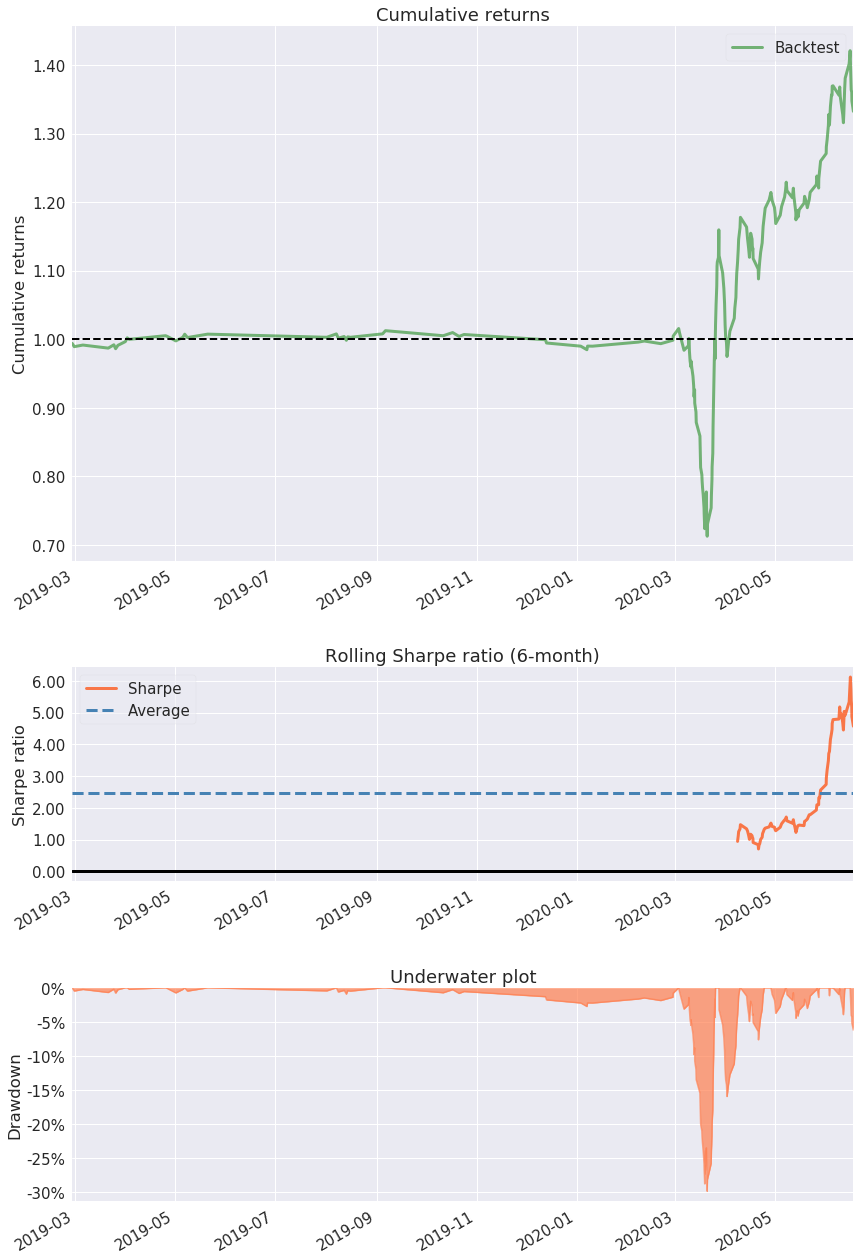

In [69]:
create_simple_tear_sheet(rtns_test['AUD/USD'][features][model])

Start date,2019-05-29
End date,2020-06-17
Total months,10
,Backtest
Annual return,1.4%
Cumulative returns,1.2%
Annual volatility,16.6%
Sharpe ratio,0.17
Calmar ratio,0.06
Stability,0.03
Max drawdown,-25.8%


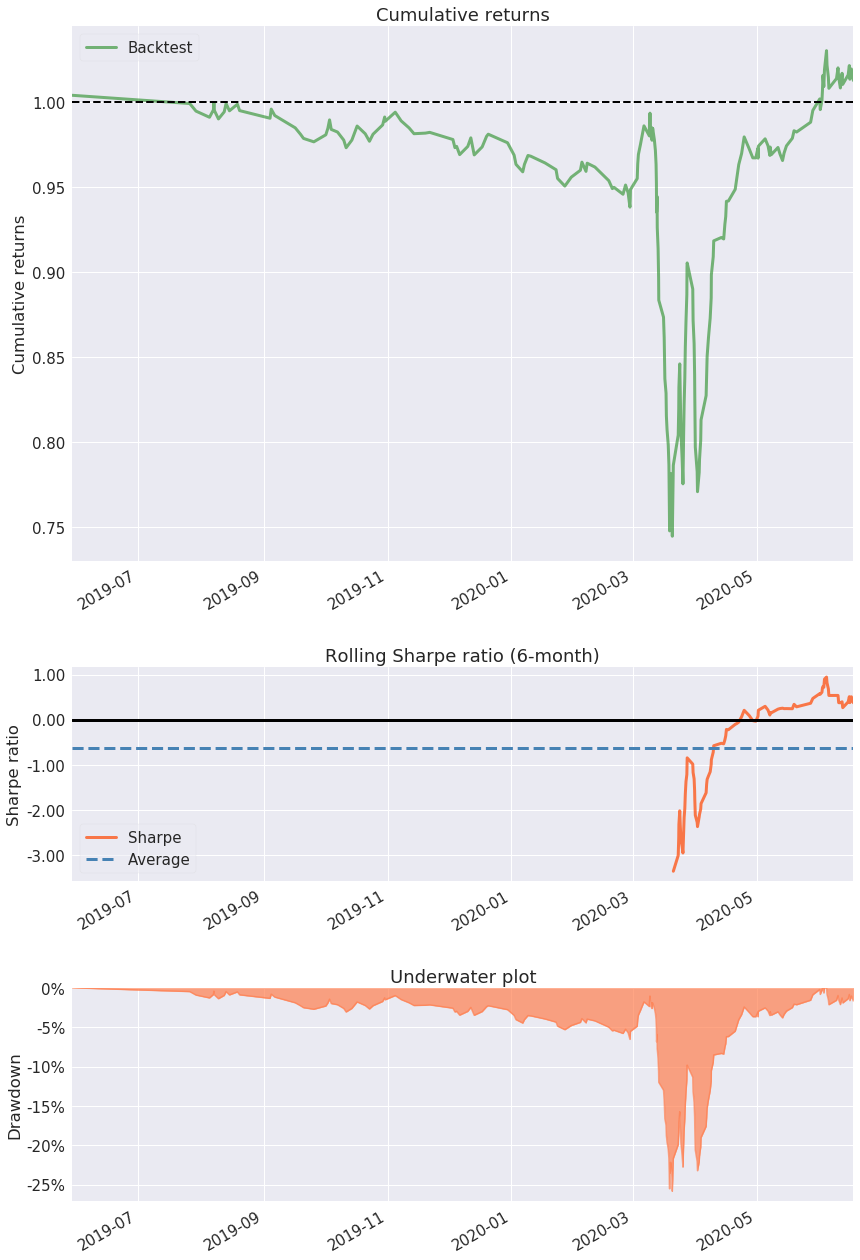

In [70]:
create_simple_tear_sheet(rtns_test['AUD/CAD'][features][model])

Start date,2019-02-15
End date,2020-06-17
Total months,10
,Backtest
Annual return,-3.7%
Cumulative returns,-3.2%
Annual volatility,20.9%
Sharpe ratio,-0.07
Calmar ratio,-0.09
Stability,0.14
Max drawdown,-40.2%


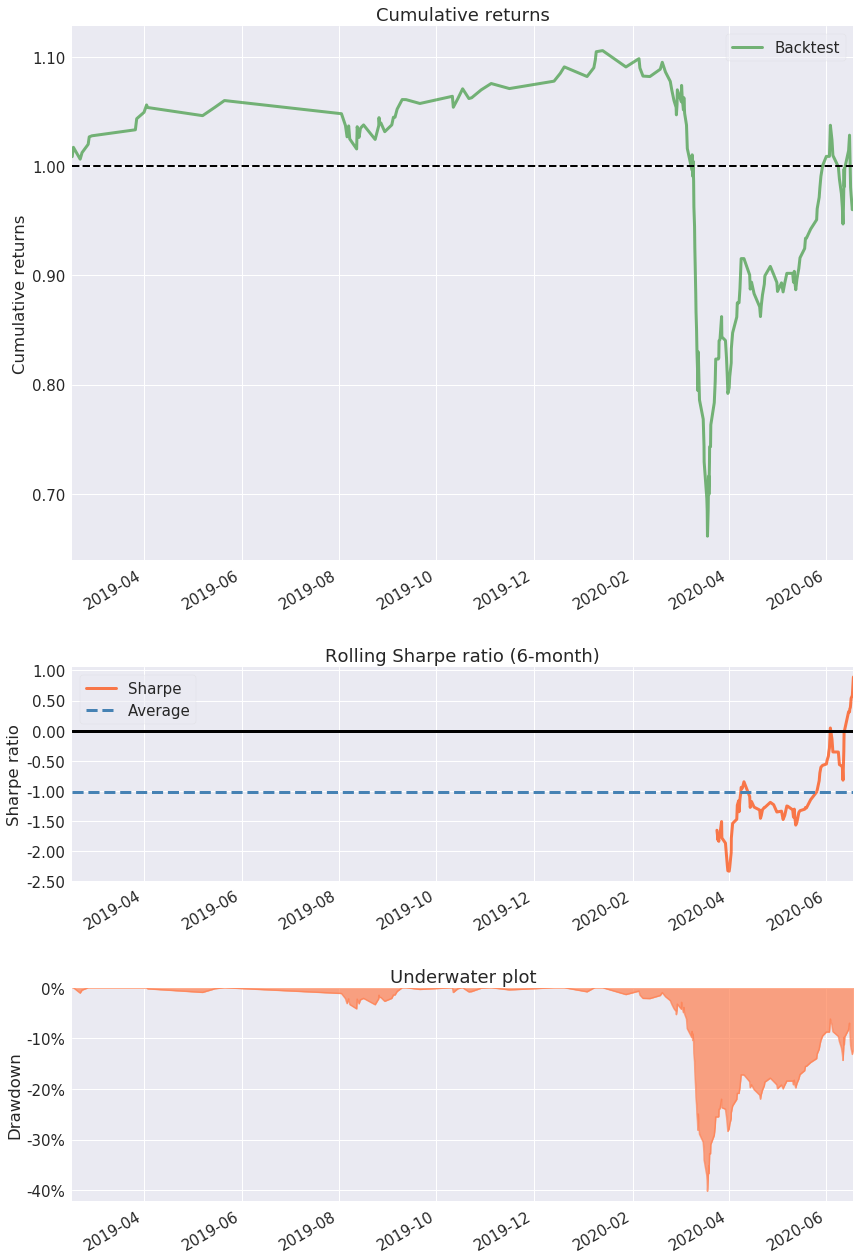

In [51]:
create_simple_tear_sheet(rtns_test['AUD/JPY'][features][model])

Start date,2019-06-20
End date,2020-06-16
Total months,10
,Backtest
Annual return,45.4%
Cumulative returns,40.3%
Annual volatility,16.4%
Sharpe ratio,2.37
Calmar ratio,3.54
Stability,0.89
Max drawdown,-12.8%


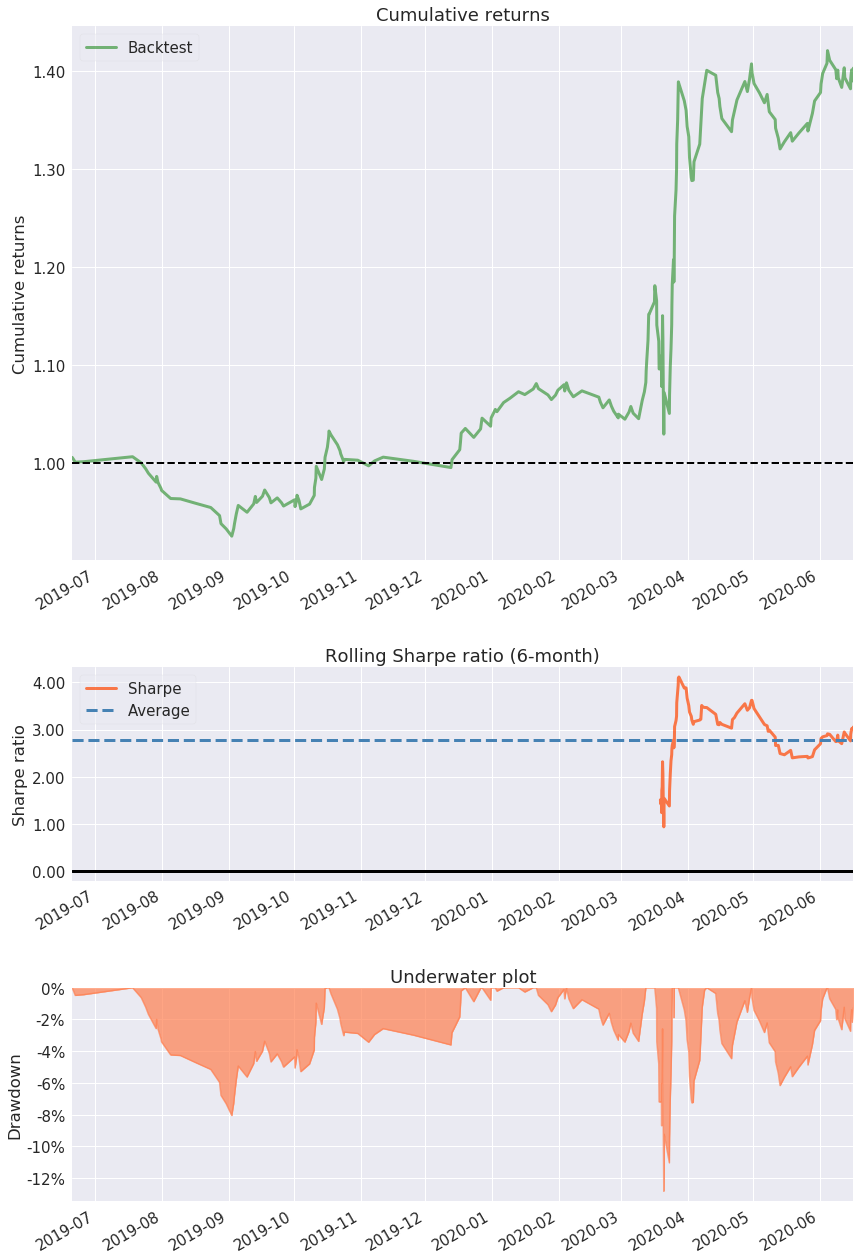

In [71]:
create_simple_tear_sheet(rtns_test['GBP/USD'][features][model])

Start date,2019-01-21
End date,2020-06-17
Total months,10
,Backtest
Annual return,40.3%
Cumulative returns,32.8%
Annual volatility,20.1%
Sharpe ratio,1.78
Calmar ratio,2.12
Stability,0.50
Max drawdown,-19.1%


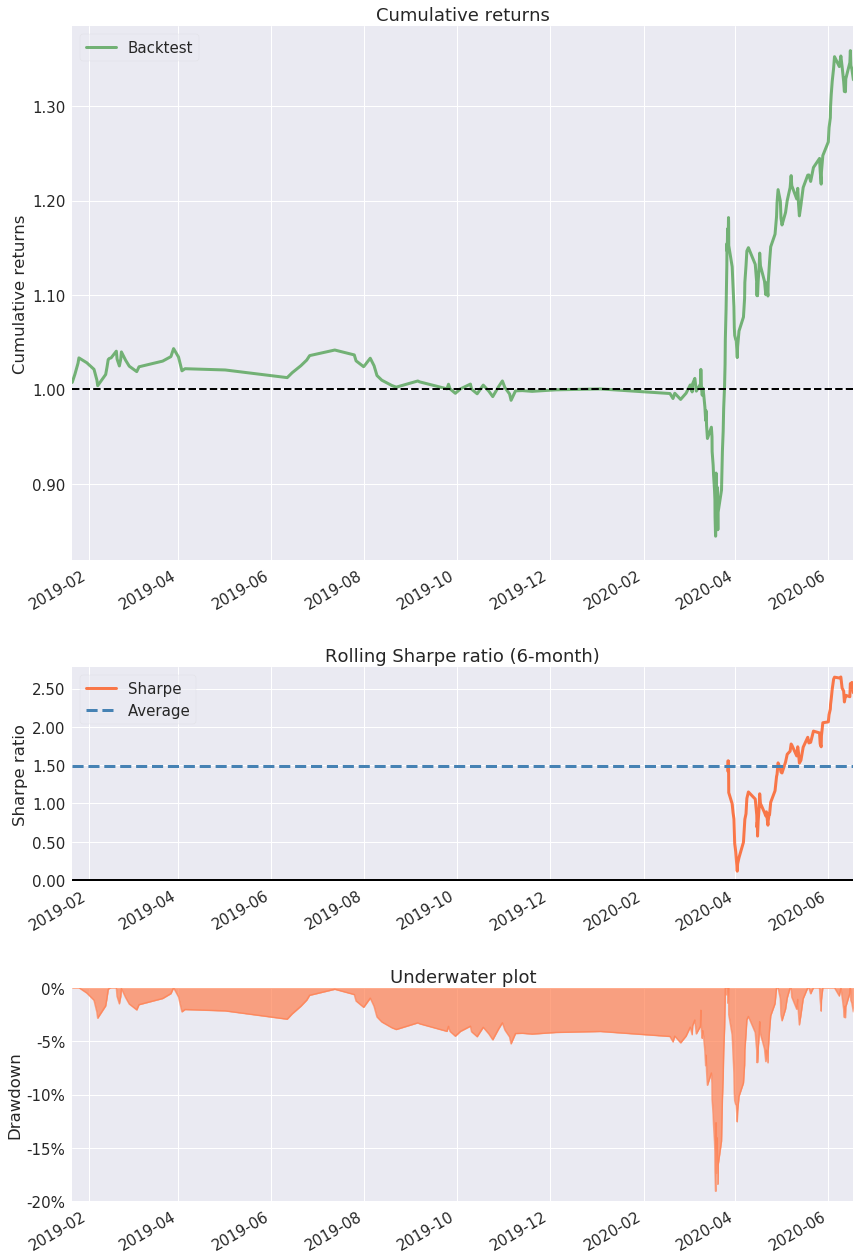

In [72]:
create_simple_tear_sheet(rtns_test['NZD/USD'][features][model])

Start date,2018-08-23
End date,2020-06-17
Total months,8
,Backtest
Annual return,7.2%
Cumulative returns,5.3%
Annual volatility,11.5%
Sharpe ratio,0.66
Calmar ratio,0.78
Stability,0.47
Max drawdown,-9.2%


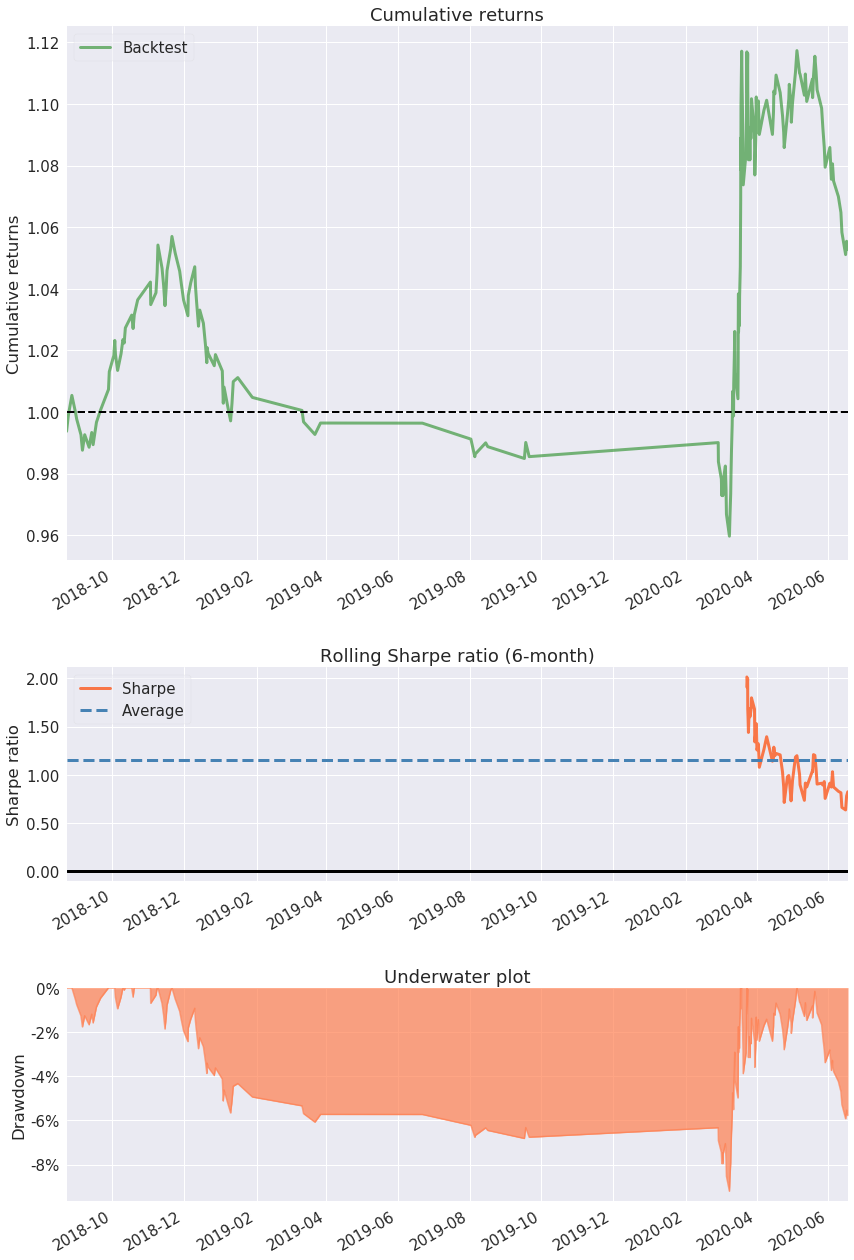

In [62]:
create_simple_tear_sheet(rtns_test['EUR/USD'][features][model])

Start date,2018-09-04
End date,2020-06-16
Total months,10
,Backtest
Annual return,23.3%
Cumulative returns,19.1%
Annual volatility,11.5%
Sharpe ratio,1.88
Calmar ratio,1.85
Stability,0.48
Max drawdown,-12.6%


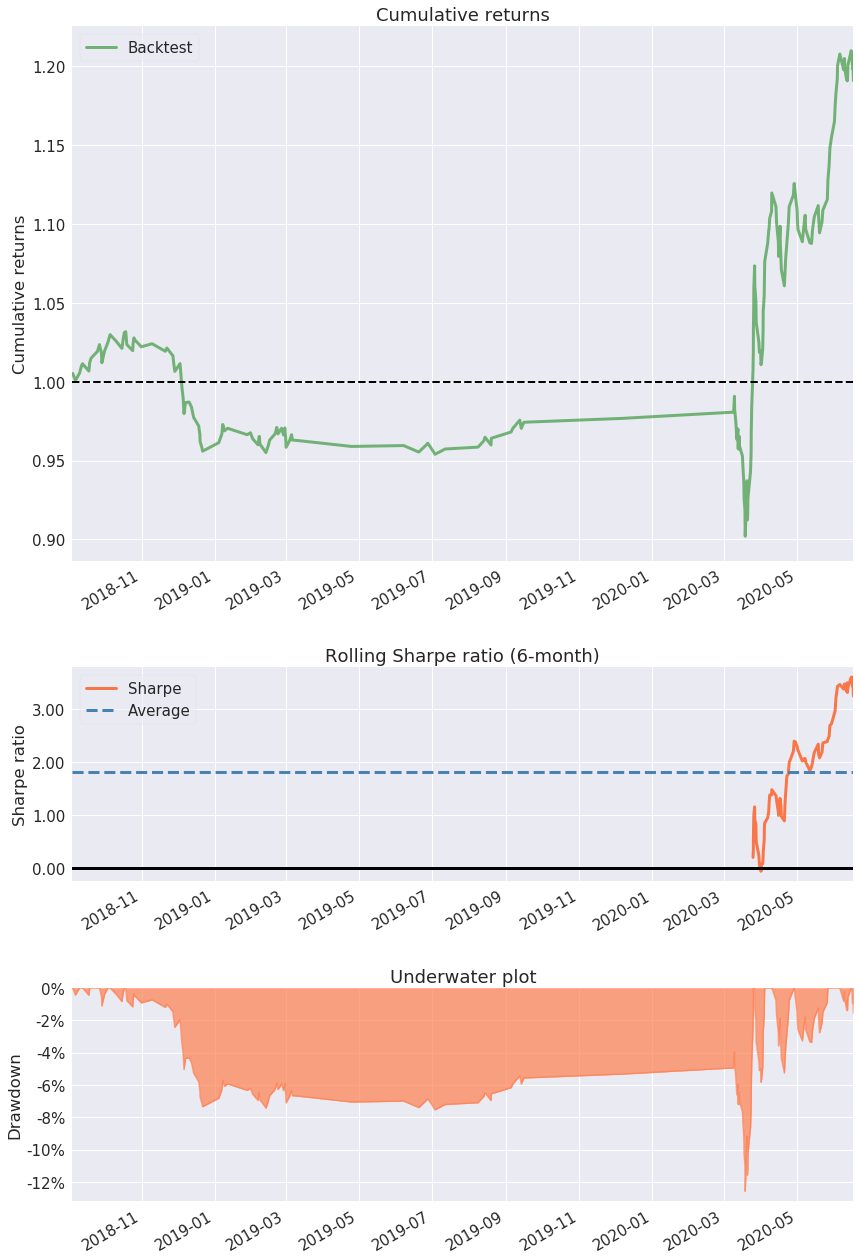

In [73]:
create_simple_tear_sheet(rtns_test['USD/CAD'][features][model])

Start date,2018-02-15
End date,2020-06-17
Total months,9
,Backtest
Annual return,60.6%
Cumulative returns,44.0%
Annual volatility,14.4%
Sharpe ratio,3.37
Calmar ratio,6.93
Stability,0.78
Max drawdown,-8.8%


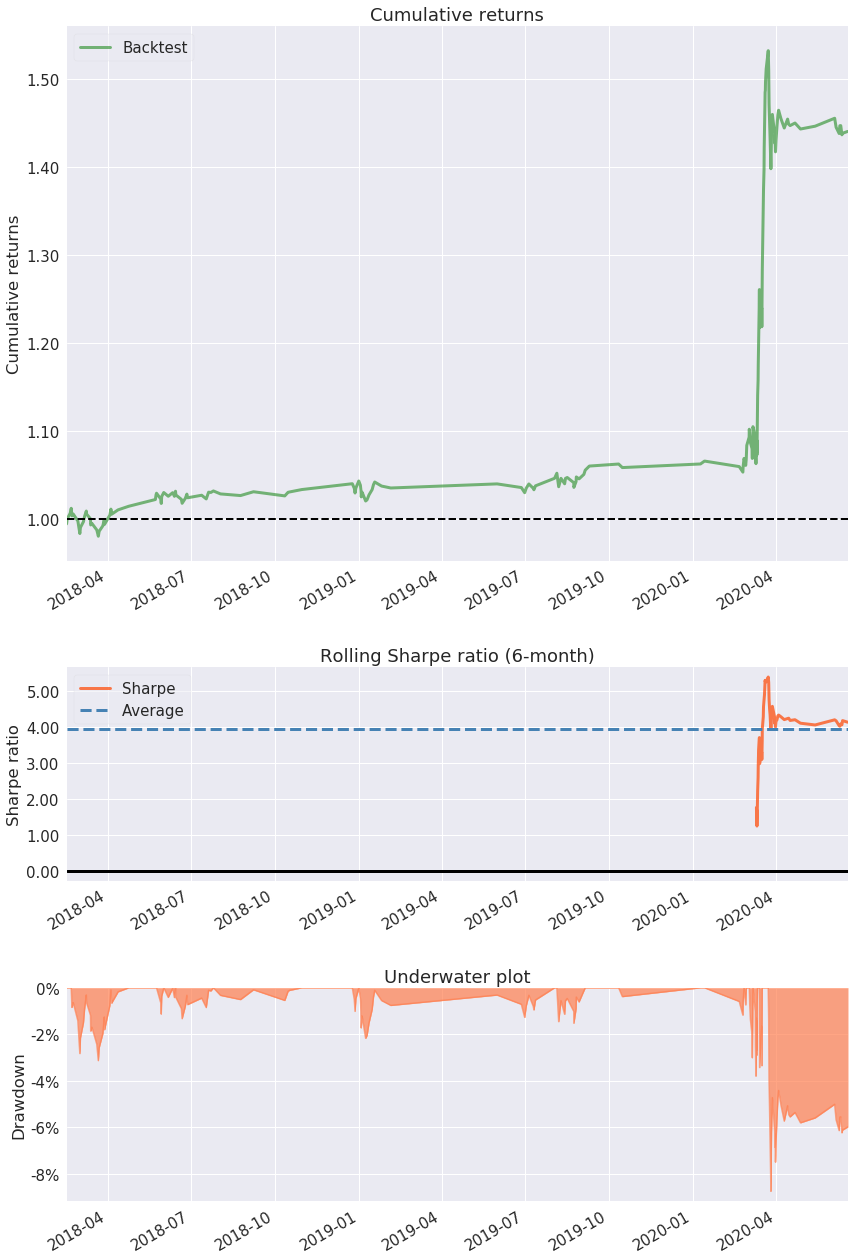

In [74]:
create_simple_tear_sheet(rtns_test['USD/JPY'][features][model])

As we can see, the differense in returns is coming from the COVID-19 shock. While returns come back to normal, it is worth taking into account that Drawdown can reach -40%.

### Conclusion
We managed to build the lifecycle of the ML model from getting the data to training models and generating trading signals. The test results show that the model built is showing positive performance including in stress conditions. In our case the Voting classifier based on weighted probabilities of classes from 4 other classifiers was chosen based on cross validation. Test results have shown positive performance as well.